In [2]:
import os
import time
import uuid
import cv2

In [3]:
import tensorflow as tf

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [6]:
# cap = cv2.VideoCapture(0)
# for imgnum in range(number_images):
#     print('Collecting image {}'.format(imgnum))
#     ret, frame = cap.read()
#     imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
#     cv2.imwrite(imgname, frame)
#     cv2.imshow('frame', frame)
#     time.sleep(0.5)
# 
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

In [7]:
# !labelme

In [8]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)

In [10]:
# images.as_numpy_iterator().next()

In [11]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [12]:
# images = images.map(load_image)

In [13]:
# images.as_numpy_iterator().next()


In [14]:
# image_generator = images.batch(4).as_numpy_iterator()

In [15]:
# plot_images = image_generator.next()

In [16]:
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx, image in enumerate(plot_images):
#     ax[idx].imshow(image)
# plt.show()

In [17]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

In [18]:
import albumentations as alb

In [19]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [20]:
img = cv2.imread(os.path.join('data', 'train', 'images', '05da3872-7899-11ee-bf54-f889d2e7af0e.jpg'))

In [21]:
img.shape

(480, 640, 3)

In [22]:
with open(os.path.join('data', 'train', 'labels', '05da3872-7899-11ee-bf54-f889d2e7af0e.json'), 'r') as f:
    label = json.load(f)

In [23]:
label['shapes'][0]['points']

[[214.69273743016757, 200.89385474860336],
 [340.3910614525139, 370.72625698324026]]

In [24]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [25]:
coords

[214.69273743016757, 200.89385474860336, 340.3910614525139, 370.72625698324026]

In [26]:
coords = list(np.divide(coords, [640,480,640,480]))

In [27]:
augmented = augmentor(image = img, bboxes=[coords], class_labels= ['face'])

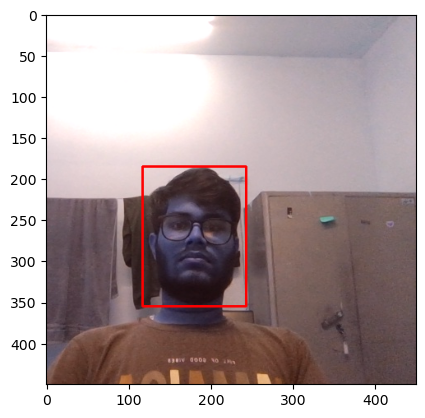

In [28]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [29]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.1242143854748603, 0.8701117318435755, 0.0, 0.5231500306437546, 'face'].
x_max is less than or equal to x_min for bbox [0.0508903631284916, 0.9445996275605214, 0.0, 0.7045667481378026, 'face'].


In [30]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [31]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [32]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [33]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding= "utf-8") as f:
        label = json.load(f)
    return [label['class']], label['bbox']    

In [34]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [35]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [36]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [37]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

In [38]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [39]:
data_samples = train.as_numpy_iterator()

In [40]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


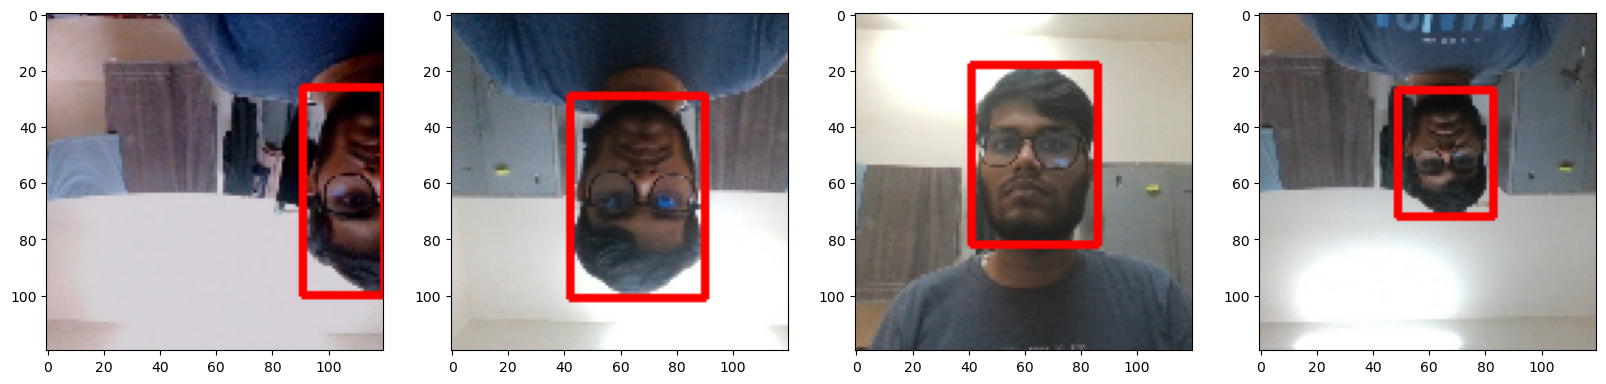

In [41]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [42]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [43]:
vgg = VGG16(include_top=False)

In [44]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [45]:
def build_model():
    input_layer = Input(shape= (120,120,3))
    
    vgg = VGG16(include_top= False)(input_layer)
    
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation = 'relu')(f1)
    class2 = Dense(1, activation = 'sigmoid')(class1)
    
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation = 'relu')(f2)
    regress2 = Dense(4, activation = 'sigmoid')(regress1)
    
    facetracker = Model(inputs= input_layer, outputs = [class2, regress2])
    return facetracker

In [46]:
facetracker = build_model()

In [47]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [48]:
len(train)

465

In [49]:
batches_per_epoch = len(train)

In [50]:
lr_decay = (1/0.75-1)/batches_per_epoch

In [51]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [52]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:, :2]))
    
    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]
    
    h_pred = yhat[:, 3] - yhat[:, 1]
    w_pred = yhat[:, 2] - yhat[:, 0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    return delta_coord + delta_size

In [53]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [54]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [55]:
model = FaceTracker(facetracker)

In [56]:
model.compile(opt, classloss, regressloss)

In [57]:
logdir = 'logs'

In [58]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [59]:
# history = model.fit(train, epochs = 15, validation_data=val,
#                  callbacks= [tensorboard_callback])

Epoch 1/15
465/465 [==============================] - 456s 973ms/step - total_loss: 0.2327 - class_loss: 0.0548 - regress_loss: 0.2053 - val_total_loss: 0.0468 - val_class_loss: 0.0011 - val_regress_loss: 0.0462
Epoch 2/15
465/465 [==============================] - 447s 952ms/step - total_loss: 0.0870 - class_loss: 0.0262 - regress_loss: 0.0739 - val_total_loss: 0.0345 - val_class_loss: 3.2102e-04 - val_regress_loss: 0.0343
Epoch 3/15
465/465 [==============================] - 443s 947ms/step - total_loss: 0.0505 - class_loss: 0.0146 - regress_loss: 0.0432 - val_total_loss: 0.0111 - val_class_loss: 3.7200e-04 - val_regress_loss: 0.0109
Epoch 4/15
465/465 [==============================] - 445s 952ms/step - total_loss: 0.0268 - class_loss: 0.0054 - regress_loss: 0.0242 - val_total_loss: 0.0233 - val_class_loss: 7.1314e-05 - val_regress_loss: 0.0232
Epoch 5/15
465/465 [==============================] - 440s 942ms/step - total_loss: 0.0260 - class_loss: 0.0058 - regress_loss: 0.0231 - val

In [60]:
history.history

{'total_loss': [0.045305222272872925,
  0.011155549436807632,
  0.019253021106123924,
  0.00853710900992155,
  0.0029116508085280657,
  0.008234662935137749,
  0.009891604073345661,
  0.0032875994220376015,
  0.016010940074920654,
  0.002040105639025569,
  0.0014291382394731045,
  0.005735579878091812,
  0.005939917638897896,
  0.000911366194486618,
  0.00381748890504241],
 'class_loss': [0.00246827257797122,
  0.0007354026893153787,
  0.0021998630836606026,
  5.430291639640927e-05,
  1.7196205590153113e-05,
  0.0003786984889302403,
  0.0014393616002053022,
  0.00020409075659699738,
  0.0027142558246850967,
  4.941466613672674e-05,
  8.307453754241578e-06,
  0.0014682614710181952,
  3.5166922316420823e-06,
  0.00011500394612085074,
  2.4661489987920504e-06],
 'regress_loss': [0.04407108575105667,
  0.010787848383188248,
  0.01815309002995491,
  0.008509957231581211,
  0.002903052605688572,
  0.008045313879847527,
  0.009171923622488976,
  0.003185553941875696,
  0.01465381309390068,
  

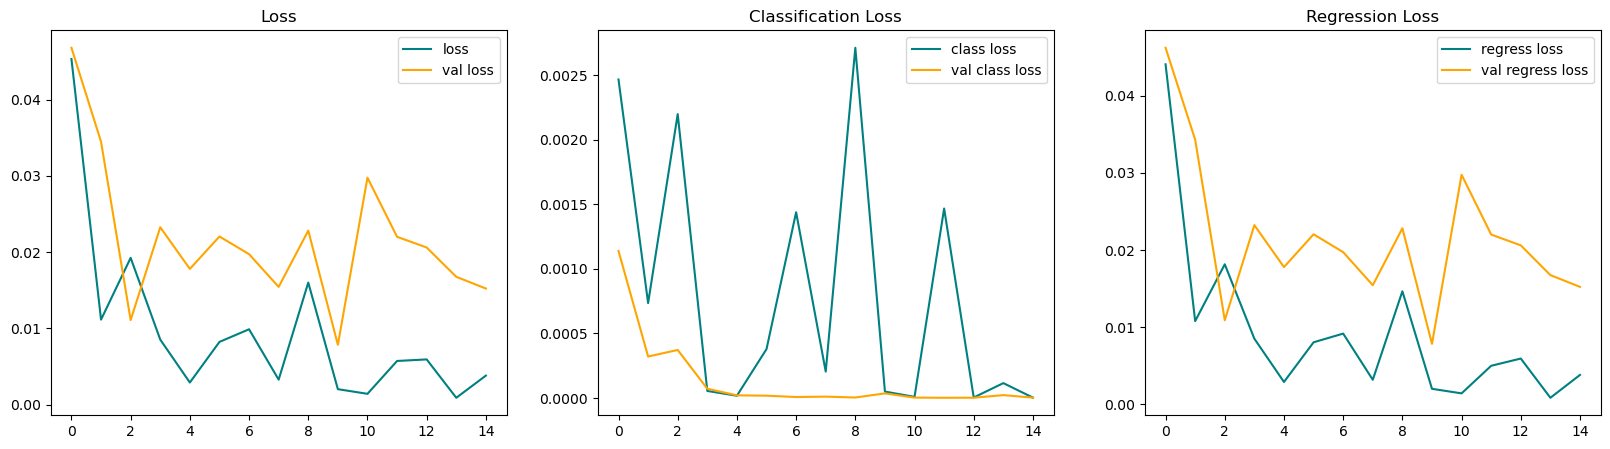

In [61]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(history.history['total_loss'], color='teal', label='loss')
ax[0].plot(history.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(history.history['class_loss'], color='teal', label='class loss')
ax[1].plot(history.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(history.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(history.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

1/1 [==============================] - 0s 480ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


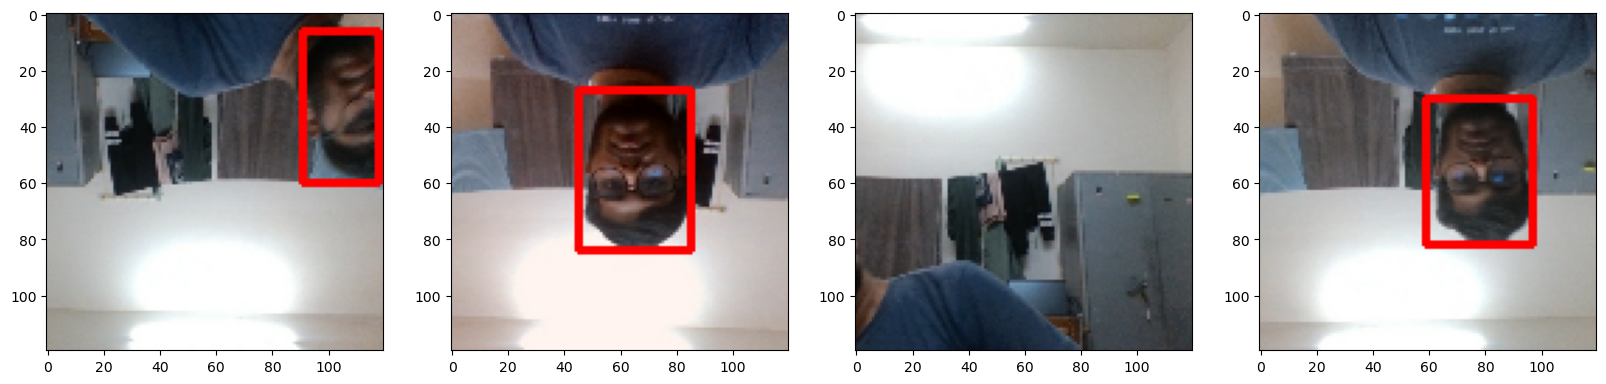

In [62]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [63]:
from tensorflow.keras.models import load_model

In [64]:
facetracker.save('facetracker.h5')
facetracker.save('copy-facetracker.h5')

In [65]:
facetracker = load_model('facetracker.h5')

In [67]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 80ms/step
